In [1]:
import json
import os
import sys
import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import Markdown as md

My imports

In [2]:
sys.path.append(os.path.join(sys.path[0], './processing/'))
from decode import decode, transform_camsph2bb, add_bb_frmcamsph

Locate dataset

In [3]:
train_list = glob.glob(os.path.join('./detection_dataset_v02-04/train/', '*.json'))
valid_list = glob.glob(os.path.join('./detection_dataset_v02-04/validation/', '*.json'))
test_list = glob.glob(os.path.join('./detection_dataset_v02-04/test/', '*.json'))
full_list = train_list + valid_list + test_list
data_lists = [full_list, train_list, valid_list, test_list]
list_counts = [len(list) for list in data_lists]
set_keys = ['Total', 'Train', 'Validation', 'Test']

Collect statistics

In [4]:
visibility = {'Visible':[0,0,0,0], 'Occluded':[0,0,0,0], 'Hidden':[0,0,0,0]}
game_type = {'Match':[0,0,0,0], 'Drill':[0,0,0,0]}
ball_size = {'Small':[0,0,0,0], 'Medium':[0,0,0,0], 'Large':[0,0,0,0]}
ball_rads = []
ball_x = []
ball_y = []
images = []
imgnames = []

SMALL_THRES = 32
LARGE_THRES = 96 

for count, name in enumerate(full_list):

    subset = 1 + count//list_counts[1] + count//(list_counts[1]+list_counts[2])

    with open(name, 'r') as input_file:
        img_dict = json.load(input_file)
        
    output_img = decode(img_dict['img'], img_dict['h_img'], img_dict['w_img'])
    m, n = output_img.shape[:2]

    ## Ball visibility ##
    if img_dict["ball_sighted"] == 1:   
        
        ball_vector = np.asarray(img_dict["ball_locate"])
        m_coord, n_coord, BALL_RAD_implane = transform_camsph2bb(output_img, ball_vector)
        
        if img_dict["occluded"] == False:
            visibility["Visible"][0] = visibility["Visible"][0] + 1
            visibility["Visible"][subset] = visibility["Visible"][subset] + 1
        
        elif img_dict["occluded"] == True:
            visibility["Occluded"][0] = visibility["Occluded"][0] + 1
            visibility["Occluded"][subset] = visibility["Occluded"][subset] + 1
            
        ## Ball size ##
        ball_rads.append(BALL_RAD_implane)
        ball_x.append(n_coord)
        ball_y.append(m_coord)
        add_bb_frmcamsph(output_img,ball_vector)
        images.append(output_img)
        imgnames.append(name[name.rfind("/")+1:-5])
        
        if 2*BALL_RAD_implane <= SMALL_THRES:
            ball_size["Small"][0] = ball_size["Small"][0] + 1
            ball_size["Small"][subset] = ball_size["Small"][subset] + 1
            
        elif 2*BALL_RAD_implane > SMALL_THRES and 2*BALL_RAD_implane < LARGE_THRES:
            ball_size["Medium"][0] = ball_size["Medium"][0] + 1
            ball_size["Medium"][subset] = ball_size["Medium"][subset] + 1
            
        elif 2*BALL_RAD_implane > LARGE_THRES:
            ball_size["Large"][0] = ball_size["Large"][0] + 1  
            ball_size["Large"][subset] = ball_size["Large"][subset] + 1           
               
    elif img_dict["ball_sighted"] == 0:
        visibility["Hidden"][0] = visibility["Hidden"][0] + 1
        visibility["Hidden"][subset] = visibility["Hidden"][subset] + 1
        images.append(output_img)
        imgnames.append(name[name.rfind("/")+1:-5])
       
    ## Game types ##
    if img_dict["type"] == "drill":   
        game_type["Drill"][0] = game_type["Drill"][0] + 1
        game_type["Drill"][subset] = game_type["Drill"][subset] + 1
            
    elif img_dict["type"] == "match":
        game_type["Match"][0] = game_type["Match"][0] + 1
        game_type["Match"][subset] = game_type["Match"][subset] + 1

Show variety

In [5]:
img_inds = []
disp_img = ["19150_outimg_WITS-FC7-4720",
            "19150_outimg_WITS-FC7-12310",
            "14817_outimg_WITS-FC2-1510",
            "12065_outimg_WITS-FC2-766",
            "12065_outimg_WITS-FC2-1356",
            "12065_outimg_WITS-FC2-432"]

for name in disp_img:
    img_inds.append(imgnames.index(name))

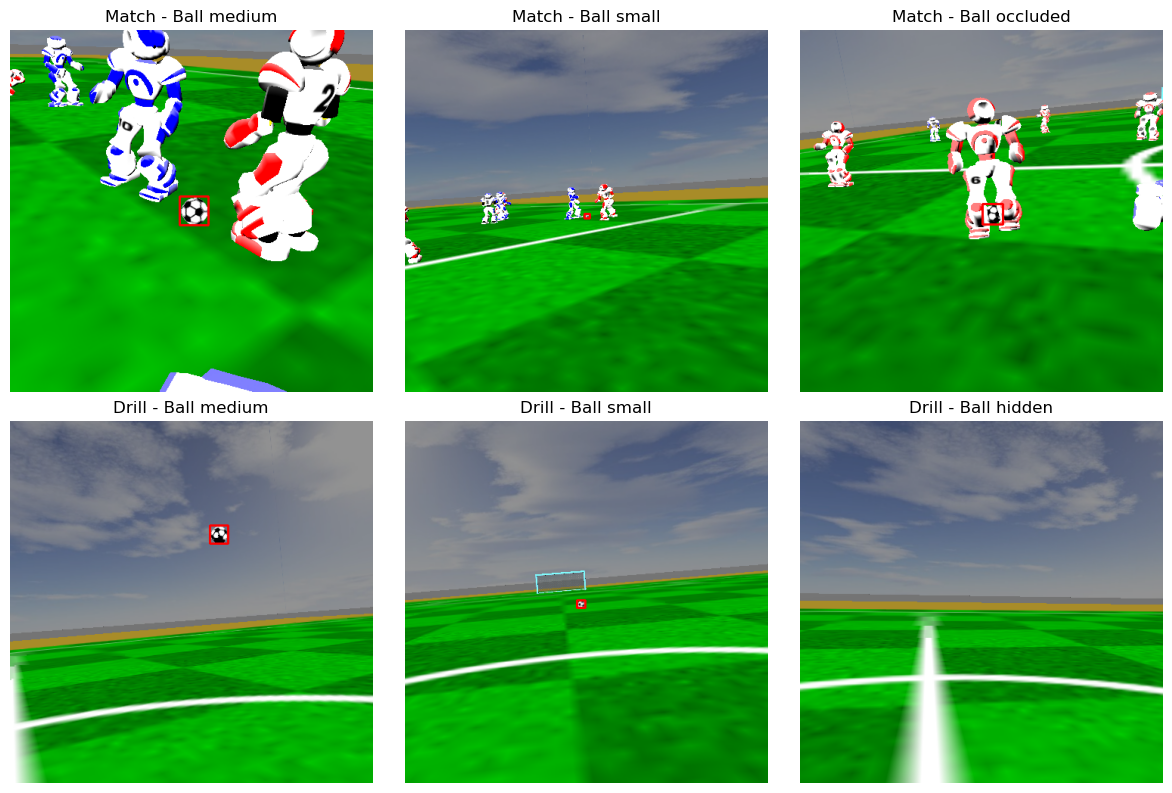

In [6]:
fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
ax=axes.ravel()

ax[0].imshow(images[img_inds[0]])
ax[0].set_title("Match - Ball medium")
ax[1].imshow(images[img_inds[1]])
ax[1].set_title("Match - Ball small")
ax[2].imshow(images[img_inds[2]])
ax[2].set_title("Match - Ball occluded")
ax[3].imshow(images[img_inds[3]])
ax[3].set_title("Drill - Ball medium")
ax[4].imshow(images[img_inds[4]])
ax[4].set_title("Drill - Ball small")
ax[5].imshow(images[img_inds[5]])
ax[5].set_title("Drill - Ball hidden")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Display stats

In [7]:
def p_tot(num):
    return num/list_counts[0]*100

In [8]:
def p_set(num, idx):
    return num[idx]/list_counts[idx]*100    

In [9]:
vis_keys = list(visibility.keys())
vis_vals = list(visibility.values())
type_keys = list(game_type.keys())
type_vals = list(game_type.values())
ball_keys = list(ball_size.keys())
ball_vals = list(ball_size.values())

In [10]:
table = (
    'Total', list_counts[0], p_tot(list_counts[0]), p_set(vis_vals[0],0), p_set(vis_vals[2],0), p_set(vis_vals[1],0), p_set(type_vals[0],0), p_set(type_vals[1],0), p_set(ball_vals[0],0), p_set(ball_vals[1],0), p_set(ball_vals[2],0),
    'Train', list_counts[1], p_tot(list_counts[1]), p_set(vis_vals[0],1), p_set(vis_vals[2],1), p_set(vis_vals[1],1), p_set(type_vals[0],1), p_set(type_vals[1],1), p_set(ball_vals[0],1), p_set(ball_vals[1],1), p_set(ball_vals[2],1),
    'Val',   list_counts[2], p_tot(list_counts[2]), p_set(vis_vals[0],2), p_set(vis_vals[2],2), p_set(vis_vals[1],2), p_set(type_vals[0],2), p_set(type_vals[1],2), p_set(ball_vals[0],2), p_set(ball_vals[1],2), p_set(ball_vals[2],2),
    'Test',  list_counts[3], p_tot(list_counts[3]), p_set(vis_vals[0],3), p_set(vis_vals[2],3), p_set(vis_vals[1],3), p_set(type_vals[0],3), p_set(type_vals[1],3), p_set(ball_vals[0],3), p_set(ball_vals[1],3), p_set(ball_vals[2],3),
)
md("""
| Dataset | No. Images | Split (%%) | Visible (%%) | Hidden (%%) | Occluded (%%) | Match (%%) | Drill (%%) | Small (%%) | Medium (%%) | Large (%%) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| %s | %i | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f |
| %s | %i | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f |
| %s | %i | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f |
| %s | %i | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f | %.1f |
"""%((table)))


| Dataset | No. Images | Split (%) | Visible (%) | Hidden (%) | Occluded (%) | Match (%) | Drill (%) | Small (%) | Medium (%) | Large (%) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Total | 2563 | 100.0 | 70.6 | 20.1 | 9.3 | 50.6 | 49.4 | 54.6 | 25.1 | 0.2 |
| Train | 1537 | 60.0 | 70.4 | 20.3 | 9.3 | 51.0 | 49.0 | 53.5 | 26.2 | 0.1 |
| Val | 513 | 20.0 | 72.9 | 18.9 | 8.2 | 51.1 | 48.9 | 58.3 | 22.8 | 0.0 |
| Test | 513 | 20.0 | 68.8 | 20.9 | 10.3 | 49.1 | 50.9 | 54.2 | 24.4 | 0.6 |


Plot object characteristics

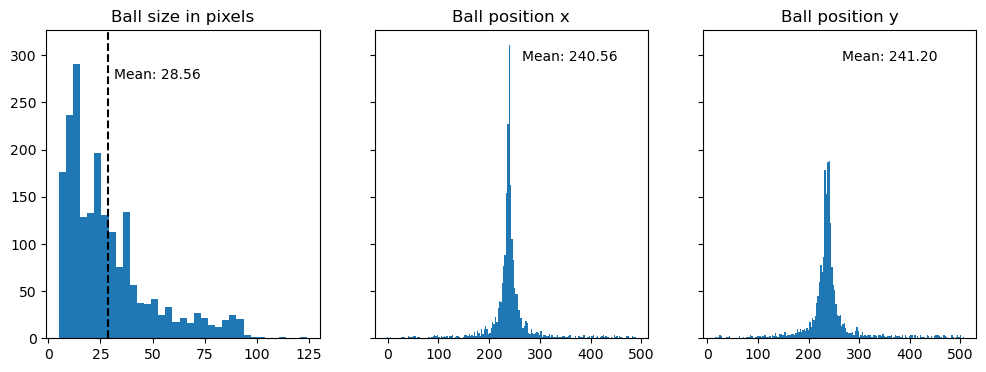

In [11]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)
ax=axes.ravel()

ball_dia = np.array(ball_rads)*2
ax[0].hist(ball_dia, bins=35)
ax[0].set_title("Ball size in pixels")
min_ylim, max_ylim = ax[0].axis()[-2:]
ax[0].axvline(ball_dia.mean(), color='k', linestyle='dashed', linewidth=1.5)
ax[0].text(ball_dia.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(ball_dia.mean()))

ball_x = np.array(ball_x)
ax[1].hist(ball_x, bins=180)
ax[1].set_title("Ball position x")
min_ylim, max_ylim = ax[1].axis()[-2:]
ax[1].text(ball_x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(ball_x.mean()))

ball_y = np.array(ball_y)
ax[2].hist(ball_y, bins=180)
ax[2].set_title("Ball position y")
min_ylim, max_ylim = ax[2].axis()[-2:]
ax[2].text(ball_y.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(ball_y.mean()))

plt.show()